# Step 1: Données

In [1]:
PATH_TO_RESSOURCES = "./Data"

In [2]:
import os

FILE_NAME_IMAGE1 = "case6_gre1.nrrd"
FILE_NAME_IMAGE2 = "case6_gre2.nrrd"
PATH_TO_IMAGE1 = os.path.join(PATH_TO_RESSOURCES, FILE_NAME_IMAGE1)
PATH_TO_IMAGE2 = os.path.join(PATH_TO_RESSOURCES, FILE_NAME_IMAGE2)

In [3]:
import itk
import numpy as np

image1 = itk.imread(PATH_TO_IMAGE1)
image2 = itk.imread(PATH_TO_IMAGE2)

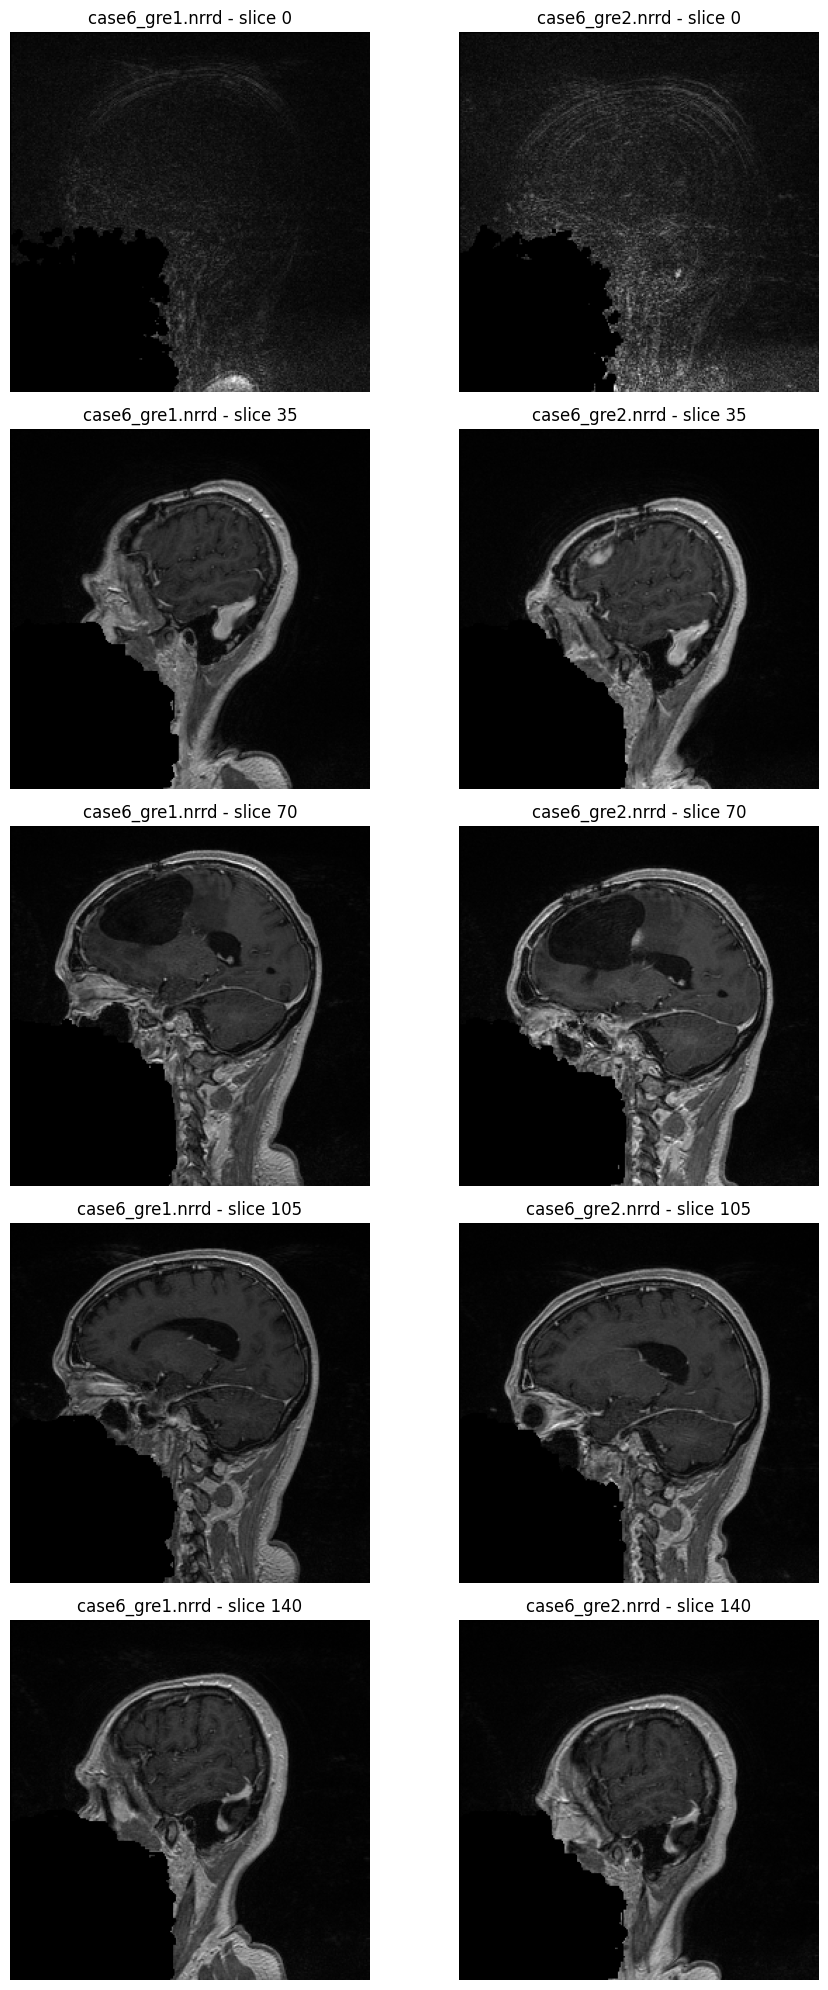

In [4]:
from matplotlib import pyplot as plt

assert image1.shape[0] == image2.shape[0]
nslices = image1.shape[0]
_, axes = plt.subplots(5, 2, figsize=(10, 20))
for ii in range(5):
    jj = ii * (nslices // 5)
    axes[ii, 0].imshow(image1[jj], cmap="gray")
    axes[ii, 0].set_title(f"{FILE_NAME_IMAGE1} - slice {jj}")
    axes[ii, 0].axis("off")
    axes[ii, 1].imshow(image2[jj], cmap="gray")
    axes[ii, 1].set_title(f"{FILE_NAME_IMAGE2} - slice {jj}")
    axes[ii, 1].axis("off")
plt.tight_layout()
plt.show()

# Step 2: Recalage d'images

In [5]:
import itk

In [6]:
pixel_t = itk.F
image_fixed = itk.imread(PATH_TO_IMAGE1, pixel_t)
image_moving = itk.imread(PATH_TO_IMAGE2, pixel_t)
image_fixed.shape, image_moving.shape

((176, 256, 256), (176, 256, 256))

In [7]:
dim = image_fixed.GetImageDimension()
image_fixed_t = type(image_fixed)
image_moving_t = type(image_moving)
image_fixed_t, image_moving_t

(itk.itkImagePython.itkImageF3, itk.itkImagePython.itkImageF3)

In [8]:
transform_t = itk.TranslationTransform[itk.D, dim]
transform_initial = transform_t.New()
transform_t

itk.itkTranslationTransformPython.itkTranslationTransformD3

In [9]:
optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)
optimizer

<itk.itkRegularStepGradientDescentOptimizerv4Python.itkRegularStepGradientDescentOptimizerv4D; proxy of <Swig Object of type 'itkRegularStepGradientDescentOptimizerv4D *' at 0x7fcef6f99ad0> >

In [10]:
metric = itk.MeanSquaresImageToImageMetricv4[image_fixed_t, image_moving_t].New()
interp_fixed = itk.LinearInterpolateImageFunction[image_fixed_t, itk.D].New()
metric.SetFixedInterpolator(interp_fixed)
metric

<itk.itkMeanSquaresImageToImageMetricv4Python.itkMeanSquaresImageToImageMetricv4IF3IF3; proxy of <Swig Object of type 'itkMeanSquaresImageToImageMetricv4IF3IF3 *' at 0x7fcef1388270> >

In [11]:
registration = itk.ImageRegistrationMethodv4[image_fixed_t, image_fixed_t].New(
    FixedImage=image_fixed,
    MovingImage=image_moving,
    Metric=metric,
    Optimizer=optimizer,
    InitialTransform=transform_initial,
)
registration

<itk.itkImageRegistrationMethodv4Python.itkImageRegistrationMethodv4REGv4F3F3; proxy of <Swig Object of type 'itkImageRegistrationMethodv4REGv4F3F3 *' at 0x7fcef6f9a5e0> >

In [12]:
transform_initial_moving = transform_t.New()
params_initial_moving = transform_initial_moving.GetParameters()
params_initial_moving.Fill(0)
transform_initial_moving.SetParameters(params_initial_moving)
registration.SetMovingInitialTransform(transform_initial_moving)

In [13]:
transform_identity = transform_t.New()
transform_identity.SetIdentity()
registration.SetFixedInitialTransform(transform_identity)

In [14]:
registration.SetNumberOfLevels(1)

In [15]:
class CommandIterationUpdate():
    def __init__(self):
        self.history = []

    def Execute(self):
        loss_value = optimizer.GetValue()
        self.history.append(loss_value)
        print(f"Iteration {optimizer.GetCurrentIteration()}: loss={loss_value:.5f}")

In [16]:
observer = CommandIterationUpdate()
command = itk.PyCommand.New()
command.SetCommandCallable(observer.Execute)
optimizer.AddObserver(itk.IterationEvent(), command)

0

In [17]:
registration.Update()

Iteration 0: loss=46299.16880
Iteration 1: loss=44616.63876
Iteration 2: loss=42755.93764
Iteration 3: loss=41781.98740
Iteration 4: loss=40596.65978
Iteration 5: loss=39045.78433
Iteration 6: loss=37609.10767
Iteration 7: loss=35631.67425
Iteration 8: loss=33519.91105
Iteration 9: loss=30881.19912
Iteration 10: loss=28085.37211
Iteration 11: loss=24791.46819
Iteration 12: loss=21325.32358
Iteration 13: loss=17242.21444
Iteration 14: loss=11815.42315
Iteration 15: loss=6733.84824
Iteration 16: loss=6403.25852
Iteration 17: loss=5633.11428
Iteration 18: loss=6928.23913
Iteration 19: loss=5906.01977
Iteration 20: loss=5631.05884
Iteration 21: loss=5637.35037
Iteration 22: loss=5608.42660
Iteration 23: loss=5627.82156
Iteration 24: loss=5614.29027
Iteration 25: loss=5610.17252
Iteration 26: loss=5611.92965
Iteration 27: loss=5613.52928
Iteration 28: loss=5613.41634
Iteration 29: loss=5614.91290
Iteration 30: loss=5614.58817
Iteration 31: loss=5613.37215
Iteration 32: loss=5614.03313
Itera

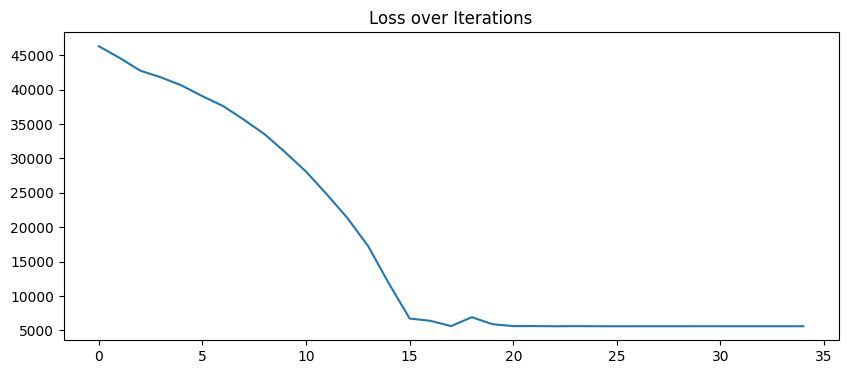

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(observer.history, label="Loss")
plt.title("Loss over Iterations")
plt.show()

In [19]:
transform = registration.GetTransform()
params_final = transform.GetParameters()
translation = [params_final.GetElement(ii) for ii in range(dim)]
number_of_iterations = optimizer.GetCurrentIteration()
best_value = optimizer.GetValue()
print("Result = ")
for ii in range(dim):
    print(f" Translation along axis {ii} = {translation[ii]}")
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Translation along axis 0 = -0.7932391841849584
 Translation along axis 1 = -3.574893649079225
 Translation along axis 2 = -59.610198718501444
 Iterations    = 36
 Metric value  = 5614.015384639906


In [20]:
transform_composite_t = itk.CompositeTransform[itk.D, dim]
transform_composite_output = transform_composite_t.New()
transform_composite_output.AddTransform(transform_initial_moving)
transform_composite_output.AddTransform(registration.GetModifiableTransform())
transform_composite_output

<itk.itkCompositeTransformPython.itkCompositeTransformD3; proxy of <Swig Object of type 'itkCompositeTransformD3 *' at 0x7fceebde5dd0> >

In [21]:
resampler = itk.ResampleImageFilter.New(
    Input=image_moving,
    Transform=transform,
    ReferenceImage=image_fixed,
    UseReferenceImage=True,
)
resampler.SetDefaultPixelValue(0)
resampler

<itk.itkResampleImageFilterPython.itkResampleImageFilterIF3IF3; proxy of <Swig Object of type 'itkResampleImageFilterIF3IF3 *' at 0x7fceebcf20d0> >

In [22]:
resampler.Update() # compute the image
image_output = resampler.GetOutput()
image_output.shape, image_output.dtype

((176, 256, 256), numpy.float32)

### Extract seed points

In [23]:
import ipywidgets as widgets
from ipywidgets import interact


def plot_alignment(ii):
    _, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(image_fixed[ii], cmap="gray")
    axes[0].set_title(f"Image Fixed - slice {ii}")
    axes[1].imshow(image_moving[ii], cmap="gray")
    axes[1].set_title(f"Image Moving - slice {ii}")
    axes[2].imshow(image_output[ii], cmap="gray")
    axes[2].set_title(f"Image Output - slice {ii}")
    plt.tight_layout()
    plt.show()


index_slider = widgets.IntSlider(
    value=image_fixed.shape[0] // 2,
    min=0,
    max=image_fixed.shape[0] - 1,
    step=1,
    description="Index:",
    continuous_update=True,
)

interact(plot_alignment, ii=index_slider)

interactive(children=(IntSlider(value=88, description='Index:', max=175), Output()), _dom_classes=('widget-int…

<function __main__.plot_alignment(ii)>

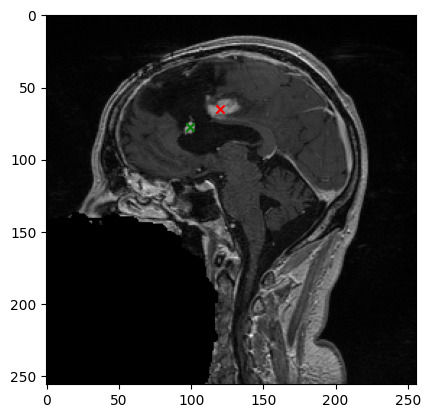

In [24]:
plt.imshow(image_fixed[84], cmap="gray")
plt.scatter([120], [65], marker="x", color="red")
plt.scatter([99], [77], marker="x", color="green")

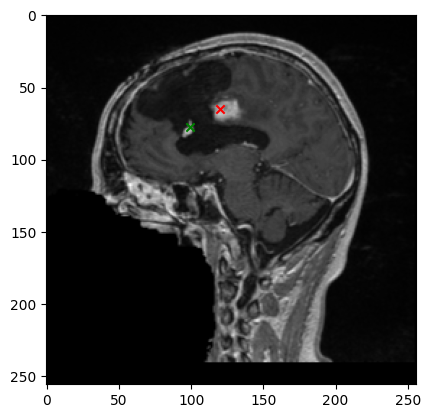

In [25]:
plt.imshow(image_output[80], cmap="gray")
plt.scatter([120], [65], marker="x", color="red")
plt.scatter([99], [77], marker="x", color="green")

# Step 3: Segmentation des tumeurs

In [26]:
def segment_tumor(image, seed_points, intensity_range=0.1):
    res = np.zeros_like(itk.array_from_image(image))
    for seed_point in seed_points:
        seed_value = image.GetPixel(seed_point)
        lower_thresh = seed_value * (1 - intensity_range)
        upper_thresh = seed_value * (1 + intensity_range)
        connected_threshold_filter = itk.ConnectedThresholdImageFilter.New(
            Input=image,
            Lower=lower_thresh,
            Upper=upper_thresh,
            ReplaceValue=1,
        )
        connected_threshold_filter.AddSeed(seed_point)
        connected_threshold_filter.Update()
        out = connected_threshold_filter.GetOutput()
        out = itk.array_from_image(out)
        res = np.maximum(res, out)
    res = itk.image_from_array(res)
    res.CopyInformation(image)
    return res


def binary_closing(image, radius=1):
    StructuringElementType = itk.FlatStructuringElement[3]
    structuring_element = StructuringElementType.Ball(radius)
    ClosingFilterType = itk.BinaryMorphologicalClosingImageFilter[
        type(image), type(image), StructuringElementType
    ]
    closing_filter = ClosingFilterType.New()
    closing_filter.SetInput(image)
    closing_filter.SetKernel(structuring_element)
    closing_filter.SetForegroundValue(1)
    closing_filter.Update()
    return closing_filter.GetOutput()

In [27]:
_IMAGE_FIXED_SEED_POINTS = [(120, 65, 84), (99, 77, 84)]  # .GetPixel uses (x, y, z)
image_fixed_segmented = segment_tumor(image_fixed, _IMAGE_FIXED_SEED_POINTS, 0.23)
image_fixed_segmented = itk.image_from_array(
    itk.array_from_image(image_fixed_segmented).astype(np.uint8)
)
image_fixed_segmented_pp = binary_closing(image_fixed_segmented)
_IMAGE_OUTPUT_SEED_POINTS = [(120, 65, 80), (99, 77, 80)]
image_output_segmented = segment_tumor(image_output, _IMAGE_OUTPUT_SEED_POINTS, 0.23)
image_output_segmented = itk.image_from_array(
    itk.array_from_image(image_output_segmented).astype(np.uint8)
)
image_output_segmented_pp = binary_closing(image_output_segmented)
image_fixed_segmented_pp.shape, image_output_segmented_pp.shape

((176, 256, 256), (176, 256, 256))

In [28]:
import ipywidgets as widgets
from ipywidgets import interact


def plot_segmentation(ii):
    _, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes[0, 0].imshow(image_fixed[ii], cmap="gray")
    axes[0, 0].set_title(f"Image Fixed - slice {ii}")
    axes[0, 1].imshow(image_fixed_segmented[ii], cmap="gray")
    axes[0, 1].set_title(f"Image Fixed Segmented - slice {ii}")
    axes[0, 2].imshow(image_fixed_segmented_pp[ii], cmap="gray")
    axes[0, 2].set_title(f"Image Fixed Segmented + PP - slice {ii}")
    axes[1, 0].imshow(image_output[ii], cmap="gray")
    axes[1, 0].set_title(f"Image Output - slice {ii}")
    axes[1, 1].imshow(image_output_segmented[ii], cmap="gray")
    axes[1, 1].set_title(f"Image Output Segmented - slice {ii}")
    axes[1, 2].imshow(image_output_segmented_pp[ii], cmap="gray")
    axes[1, 2].set_title(f"Image Output Segmented + PP - slice {ii}")
    plt.tight_layout()
    plt.show()


index_slider = widgets.IntSlider(
    value=image_fixed.shape[0] // 2,
    min=0,
    max=image_fixed.shape[0] - 1,
    step=1,
    description="Index:",
    continuous_update=True,
)

interact(plot_segmentation, ii=index_slider)

interactive(children=(IntSlider(value=88, description='Index:', max=175), Output()), _dom_classes=('widget-int…

<function __main__.plot_segmentation(ii)>

# Step 4: Analyse et visualisation des changements

In [29]:
image_diff = itk.image_from_array(
    itk.array_from_image(image_fixed_segmented_pp).astype(np.float32)
    - itk.array_from_image(image_output_segmented_pp).astype(np.float32)
)
image_diff.shape, image_diff.dtype

((176, 256, 256), numpy.float32)

In [30]:
import vtk


def visualize_difference(difference_image):
    vtk_diff_image = itk.vtk_image_from_image(difference_image)
    mapper = vtk.vtkSmartVolumeMapper()
    mapper.SetInputData(vtk_diff_image)
    color_func = vtk.vtkColorTransferFunction()
    color_func.AddRGBPoint(-1, 1, 0, 0)
    color_func.AddRGBPoint(0, 0, 0, 0)
    color_func.AddRGBPoint(1, 0, 1, 0)
    opacity_func = vtk.vtkPiecewiseFunction()
    opacity_func.AddPoint(-1, 0.5)
    opacity_func.AddPoint(0, 0)
    opacity_func.AddPoint(1, 0.5)
    volume_property = vtk.vtkVolumeProperty()
    volume_property.SetColor(color_func)
    volume_property.SetScalarOpacity(opacity_func)
    volume = vtk.vtkVolume()
    volume.SetMapper(mapper)
    volume.SetProperty(volume_property)
    renderer = vtk.vtkRenderer()
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)
    renderer.AddVolume(volume)
    renderer.SetBackground(0, 0, 0)
    render_window.Render()
    interactor.Start()

In [31]:
visualize_difference(image_diff)

# Fin